In [5]:
import geopandas as gpd
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Make sure the path to the shapefile is correct
shapefile_path = '/home/gabriel/Downloads/archive(3)/BRA_adm1.shp'
gdf_brazil = gpd.read_file(shapefile_path)


In [3]:
# Make sure the path to the NetCDF file is correct
netcdf_path = '/home/gabriel/Downloads/archive(2)/precip.mon.total.v7.nc'
ds = xr.open_dataset(netcdf_path)


In [6]:
# Aggregate the data by taking the mean across the 'time' dimension
precip_mean = ds['precip'].mean(dim='time')

# Flatten the data
precip_flat = precip_mean.values.flatten()
lats = ds['lat'].values
lons = ds['lon'].values
lat_expanded = np.repeat(lats, len(lons))
lon_expanded = np.tile(lons, len(lats))

# Create a DataFrame
df_precip = pd.DataFrame({
    'Latitude': lat_expanded,
    'Longitude': lon_expanded,
    'Precipitation': precip_flat
})


In [7]:
# Convert the DataFrame to a GeoDataFrame
gdf_precip = gpd.GeoDataFrame(df_precip, geometry=gpd.points_from_xy(df_precip.Longitude, df_precip.Latitude))
gdf_precip.set_crs(epsg=4326, inplace=True)


,Latitude,Longitude,Precipitation,geometry
0,89.75,0.25,NaN,POINT (0.25000 89.75000)
1,89.75,0.75,NaN,POINT (0.75000 89.75000)
2,89.75,1.25,NaN,POINT (1.25000 89.75000)
3,89.75,1.75,NaN,POINT (1.75000 89.75000)
4,89.75,2.25,NaN,POINT (2.25000 89.75000)
...,...,...,...,...
259195,-89.75,357.75,NaN,POINT (357.75000 -89.75000)
259196,-89.75,358.25,NaN,POINT (358.25000 -89.75000)
259197,-89.75,358.75,NaN,POINT (358.75000 -89.75000)
259198,-89.75,359.25,NaN,POINT (359.25000 -89.75000)


In [10]:
gdf_joined = gpd.sjoin(gdf_precip, gdf_brazil, how="inner", predicate='intersects')


In [11]:
# Replace 'NAME_1' with the actual name of the column containing state names in your shapefile
precip_by_state = gdf_joined.groupby('NAME_1')['Precipitation'].mean().reset_index()


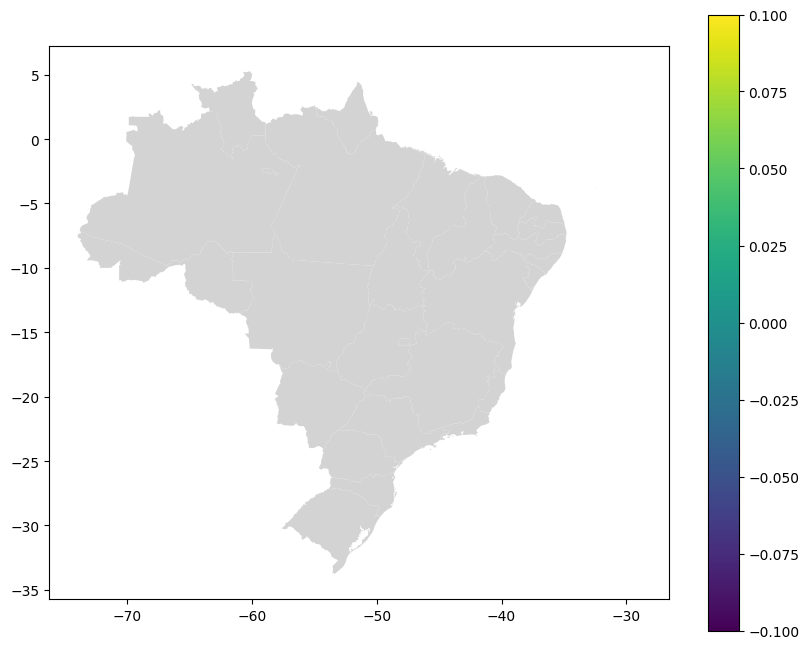

In [16]:
# Merge the results back with the Brazil GeoDataFrame to get geometries for plotting
gdf_brazil = gdf_brazil.merge(precip_by_state, left_on='NAME_1', right_on='NAME_1', how='left')

# Plot the Brazil map with mean precipitation by state
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf_brazil.plot(column='Precipitation', ax=ax, legend=True, missing_kwds={'color': 'lightgrey'})
plt.show()

In [17]:
# Assuming 'Precipitation' is the column with your precipitation data
min_precip = gdf_brazil['Precipitation'].min()
max_precip = gdf_brazil['Precipitation'].max()

print(f"Minimum Precipitation: {min_precip}")
print(f"Maximum Precipitation: {max_precip}")


Minimum Precipitation: nan
Maximum Precipitation: nan


In [18]:
gdf_brazil['Precipitation'] = gdf_brazil['Precipitation'].fillna(0)

min_precip = gdf_brazil['Precipitation'].min()
max_precip = gdf_brazil['Precipitation'].max()

print(f"Minimum Precipitation: {min_precip}")
print(f"Maximum Precipitation: {max_precip}")


Minimum Precipitation: 0.0
Maximum Precipitation: 0.0


In [20]:
print(gdf_brazil['NAME_1'].head())
print(precip_by_state['NAME_1'].head())  


0        Acre
1     Alagoas
2       Amapá
3    Amazonas
4       Bahia
Name: NAME_1, dtype: object
Series([], Name: NAME_1, dtype: object)
